# Special aspects

In this section we will discuss a number of issues and questions relating to core spectroscopies, ranging from the physical effect of a core-transition, to technical aspects relating to lowering computational costs. They are ordered by approximate relevance, with some topics being pertient only for certain cases.


(sec:xray_topics_relax)=
## Relaxation

Core spectroscopies exhibit strong relaxation effects, originating in the significant change in shielding of the nuclear charge arising from the creation/annihilation of a core-hole. These effects need to be properly accounted for in order to get good absolute energies, as  the lack of this will mean that, *e.g.* an unrelaxed core-hole system is too high in energy. This explains the previously [observed](sec:xray_calc_iekoop) large error obtained using Koopmans' theorem.

### Relaxation of core-ionized systems

In {numref}`relax_form` we see the effects of relaxation for creating a core-hole in the oxygen/carbon 1s of formaldehyde:

```{figure} ../../img/xray/relax_form.png
---
name: relax_form
---
The total electron density of formaldehyde, featuring the neutral system and core-ionized at the carbon and oxygen 1s.
```

We see that there is a noticable attraction of electron density toward the core-holes, as marked with a **+**. These effects can be modeled with the $Z+1$ approximation, within which the change in screening is modeled by substituting the ionized atom with the next element in the periodic table. This can be illustrated with the following radial distribution plots (using uncontracted 6-31G basis sets, in order to increase flexibility in the core region):

In [12]:
import copy
import adcc
import matplotlib.pyplot as plt
import numpy as np
from pyscf import gto, mp, scf
au2ev = 27.211386


def lorentzian(x, y, xmin, xmax, xstep, gamma):
    """
    Lorentzian broadening function

    Call: xi,yi = lorentzian(energies, intensities, start energy,
                                    end energy, energy step, gamma)
    """
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = (
                yi[i]
                + y[k] * gamma / ((xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2) / np.pi
            )
    return xi, yi

In [6]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""
water_fluorine_xyz = """
F       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

### SCF of neutral and core-hole water
# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = "unc-6-31G"
mol.build()
# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()
# Copy molecular orbitals
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)
# Create 1s core-hole by setting beta_0 population to zero
occ0[1][0] = 0.0
# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

### SCF of FO2 (Z+1 model)
# Create pyscf mol object
mol_fl = gto.Mole()
mol_fl.atom = water_fluorine_xyz
mol_fl.basis = "unc-6-31G"
mol_fl.charge = 1  # Closed-shell
mol_fl.build()
# Perform unrestricted SCF calculation
scf_gs_fl = scf.UHF(mol_fl)
scf_gs_fl.kernel()

Ay = 0.0  # oxygen y-position (in au)
Az = 0.1178336003 / 0.529177249  # oxygen z-position (in au)

# Create coordinate object along x-axis (intersecting with O/F atom)
coords = []
for ix in np.arange(-4, 4, 0.001):
    coords.append((ix, Ay, Az))
coords = np.array(coords)

# AO values and MO values on given grids
# Neutral water
ao_gs = mol.eval_gto("GTOval_sph", coords)
mo_gs = ao_gs.dot(scf_gs.mo_coeff)

# Water core-hole
ao_ion = mol.eval_gto("GTOval_sph", coords)
mo_ion = ao_ion.dot(scf_ion.mo_coeff)

# FO2
ao_Z1 = mol_fl.eval_gto("GTOval_sph", coords)
mo_Z1 = ao_Z1.dot(scf_gs_fl.mo_coeff)

converged SCF energy = -75.9890271783204  <S^2> = 8.9110941e-12  2S+1 = 1
converged SCF energy = -56.1707263747174  <S^2> = 0.76785153  2S+1 = 2.0177726
converged SCF energy = -100.169768736219  <S^2> = 4.3698378e-13  2S+1 = 1


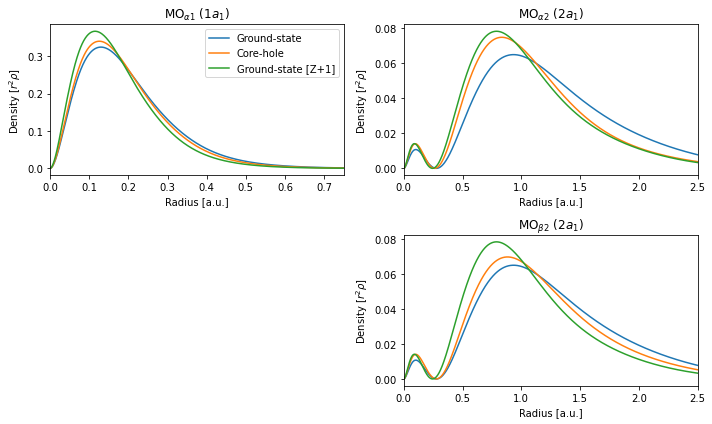

In [5]:
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.title(r"MO$_{\alpha 1}$ ($1a_1$)")
mo_nr = 0
r, rho1, rho2, rho3 = [], [], [], []
for i in np.arange(len(coords)):
    r.append(coords[i][0])
    rho1.append(coords[i][0] ** 2 * mo_gs[i][0][mo_nr] ** 2)
    rho2.append(coords[i][0] ** 2 * mo_ion[i][0][mo_nr] ** 2)
    rho3.append(coords[i][0] ** 2 * mo_Z1[i][0][mo_nr] ** 2)
plt.plot(r, rho1)
plt.plot(r, rho2)
plt.plot(r, rho3)
plt.legend(("Ground-state", "Core-hole", "Ground-state [Z+1]"))
plt.xlim((0, 0.75))
plt.xlabel("Radius [a.u.]")
plt.ylabel(r"Density [$r^2 \rho$]")

plt.subplot(222)
plt.title(r"MO$_{\alpha 2}$ ($2a_1$)")
mo_nr = 1
r, rho1, rho2, rho3 = [], [], [], []
for i in np.arange(len(coords)):
    r.append(coords[i][0])
    rho1.append(coords[i][0] ** 2 * mo_gs[i][0][mo_nr] ** 2)
    rho2.append(coords[i][0] ** 2 * mo_ion[i][0][mo_nr] ** 2)
    rho3.append(coords[i][0] ** 2 * mo_Z1[i][0][mo_nr] ** 2)
plt.plot(r, rho1)
plt.plot(r, rho2)
plt.plot(r, rho3)
plt.xlim((0, 2.5))
plt.xlabel("Radius [a.u.]")
plt.ylabel(r"Density [$r^2 \rho$]")

plt.subplot(224)
plt.title(r"MO$_{\beta 2}$ ($2a_1$)")
mo_nr = 1
r, rho1, rho2, rho3 = [], [], [], []
for i in np.arange(len(coords)):
    r.append(coords[i][0])
    rho1.append(coords[i][0] ** 2 * mo_gs[i][1][mo_nr] ** 2)
    rho2.append(coords[i][0] ** 2 * mo_ion[i][1][mo_nr] ** 2)
    rho3.append(coords[i][0] ** 2 * mo_Z1[i][1][mo_nr] ** 2)
plt.plot(r, rho1)
plt.plot(r, rho2)
plt.plot(r, rho3)
plt.xlim((0, 2.5))
plt.xlabel("Radius [a.u.]")
plt.ylabel(r"Density [$r^2 \rho$]")

plt.tight_layout()
plt.show()

As can be seen, the radial distribution of particularly $\alpha_2$ for the core-ionized system is closer to $Z+1$ than to the neutral state, while for $\alpha_1$ and $\beta_2$ it is closer to that of the ground state. Also note the differences in the x-scales, with $\alpha_1$ being more compressed and thus having a larger peak max.


### Relaxation of core-(de)excitation

For X-ray absorption and emission spectroscopy the influence of the relaxation is more complex, on account of the interaction with the created singly-occupied state. Comparing the two spectroscopies, the relaxation processes are partially inverse to each other, with


- Relaxation in XAS leading to a more contracted final state, which lowers absorption energies

- Relaxation in XES leading to a more decontracted final state, which increases emission energies

In addition to these strong changes in shielding, there are also additional couplings due to the population of a previous unoccupied state (XAS) or the creation of a valence-hole (XES). These effects are smaller and partially counteract the stronger change in shielding from the occupied/unoccupied core orbital, leading to a total picture as [follows](https://pubs.acs.org/doi/10.1021/acs.jctc.8b01046):

```{figure} ../../img/xray/relax_processes.svg
---
name: relax_processes
---
Relaxation effects involved in X-ray absorption (left) and emission (right) spectroscopies. Showing which orbitals primarily contribute to the respective effects, as well as the result in MO energies (or electron densities).
```

We here see the four main effects:

- X-ray absorption spectroscopy

    1. A strong relaxation effect due to the creation of a core-hole, which leads to the contraction of electron density and scales with element
    
    2. A weak polarization effect due to coupling with the newly occupied valence state, which partially decontracts the outer valence density and does not scale appreciably with the element
    
- X-ray emission spectroscopy

    1. A strong repulsion effect due to the annihilation of a core-hole, which leads to decontraction of electron density and scales with element
    
    2. A weaker outer relaxation effect due to the creation of a valence-hole, which leads to contraction of the (outer) valence density and scales with element

These effects balances in different manners, and the exact strength depends heavily on the element and which edge is being probed. As such, the accuracy of a particular method depends on which spectroscopy, element, and edge is considered.


(sec:xray_delta_rel)=
### Including relaxation with $\Delta$SCF methods

$\Delta$SCF methods provide the most direct way of including relaxation, as the core-hole state is explicitly optimized. However, these approaches need to consider each transition explicitly, and will have difficulties in calculating intensities and in properly converging higher excited states. As such, they are mainly useful for considering ionization energies and for providing a reference state for XES calculations. Comparing the performance of calculating IEs of the ten-electron series using Koopmans' theorem and $\Delta$SCF:


```python
methane_xyz = """
C       0.0000000000     0.0000000000     0.0000000000
H       0.6265918120     0.6265918120     0.6265918120
H      -0.6265918120    -0.6265918120     0.6265918120
H      -0.6265918120     0.6265918120    -0.6265918120
H       0.6265918120    -0.6265918120    -0.6265918120
"""
ammonia_xyz = """
N       0.0000000000     0.0000000000     0.1175868000
H       0.9323800000     0.0000000000    -0.2743692000
H      -0.4661900000    -0.8074647660    -0.2743692000
H      -0.4661900000     0.8074647660    -0.2743692000
"""
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""
hydrofluoride_xyz = """
H       0.0000000000     0.0000000000    -0.8261856000
F       0.0000000000     0.0000000000     0.0917984000
"""
neon_xyz = """
Ne      0.0000000000     0.0000000000     0.0000000000
"""


def Koopman_vs_delta(molecule, basis):
    # Create pyscf mol object
    mol = gto.Mole()
    mol.atom = molecule
    mol.basis = basis
    mol.build()
    # Perform unrestricted SCF calculation
    scf_gs = scf.UHF(mol)
    scf_gs.kernel()
    # Copy molecular orbitals
    mo0 = copy.deepcopy(scf_gs.mo_coeff)
    occ0 = copy.deepcopy(scf_gs.mo_occ)
    # Create 1s core-hole by setting alpha_0 population to zero
    occ0[0][0] = 0.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Return MO energy and deltaSCF
    return -au2ev * scf_gs.mo_energy[0][0], au2ev * (
        scf_ion.energy_tot() - scf_gs.energy_tot()
    )


# Basis set and container for errors
basis = "unc-6-31G"
err_koopman, err_delta = [], []

expt, rel = 290.76, 0.11  # experimental IE and scalar-relativistic effects
E_Koopman, E_delta = Koopman_vs_delta(methane_xyz, basis)
err_koopman.append(E_Koopman + rel - expt)
err_delta.append(E_delta + rel - expt)

expt, rel = 405.52, 0.21  # experimental IE and scalar-relativistic effects
E_Koopman, E_delta = Koopman_vs_delta(ammonia_xyz, basis)
err_koopman.append(E_Koopman + rel - expt)
err_delta.append(E_delta + rel - expt)

expt, rel = 539.90, 0.37  # experimental IE and scalar-relativistic effects
E_Koopman, E_delta = Koopman_vs_delta(water_xyz, basis)
err_koopman.append(E_Koopman + rel - expt)
err_delta.append(E_delta + rel - expt)

expt, rel = 694.10, 0.61  # experimental IE and scalar-relativistic effects
E_Koopman, E_delta = Koopman_vs_delta(hydrofluoride_xyz, basis)
err_koopman.append(E_Koopman + rel - expt)
err_delta.append(E_delta + rel - expt)

expt, rel = 870.09, 0.94  # experimental IE and scalar-relativistic effects
E_Koopman, E_delta = Koopman_vs_delta(neon_xyz, basis)
err_koopman.append(E_Koopman + rel - expt)
err_delta.append(E_delta + rel - expt)
```

```python
plt.figure(figsize=(7, 4))
# Plot error from MO energies and delta-SCF
plt.plot([1, 2, 3, 4, 5], err_koopman, "bs")
plt.plot([1, 2, 3, 4, 5], err_delta, "ro")
plt.plot([0.5, 5.5], [0, 0], "k--", zorder=0)

plt.legend(("Koopmans' theorem", r"$\Delta$SCF"))
plt.ylabel("Error wrt experiment [eV]")
plt.xticks([1, 2, 3, 4, 5], (r"CH$_4$", r"NH$_3$", r"H$_2$O", "HF", "Ne"))
plt.xlim((0.5, 5.5))
plt.tight_layout()
plt.show()
```

```{figure} ../../img/xray/relax_scf.svg
---
name: xray_relax_scf
scale: 6%
---
```

We see that the error from orbital energies is large (14.4-22.3 eV) and clearly scales with atomic number, while the error of $\Delta$SCF remains small (absolute error of 0.15-0.38 eV). 


### Including relaxation with wave-function methods

Considering the X-ray absorption and emission spectrum of water, the error of ADC(*n*) calculations with respect to experimental measurements can be considered:


```python
# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = "unc-6-31G"
mol.build()

# Perform restricted SCF calculation
scf_gs = scf.RHF(mol)
scf_gs.kernel()

# Perform CVS-ADC calculations
xas_adc1 = adcc.cvs_adc1(scf_gs, n_singlets=2, core_orbitals=1)
xas_adc2 = adcc.cvs_adc2(scf_gs, n_singlets=2, core_orbitals=1)
xas_adc2x = adcc.cvs_adc2x(scf_gs, n_singlets=2, core_orbitals=1)
xas_adc3 = adcc.cvs_adc3(scf_gs, n_singlets=2, core_orbitals=1)

# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()

# Copy molecular orbitals
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0

# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Perform ADC calculations
xes_adc1 = adcc.adc1(scf_ion, n_states=2)
xes_adc2 = adcc.adc2(scf_ion, n_states=2)
xes_adc2x = adcc.adc2x(scf_ion, n_states=2)
xes_adc3 = adcc.adc3(scf_ion, n_states=2)
```

Plotting the errors compared to experiment (given as a dashed line), and the variations in oscillator strength:

```python
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.title("XAS energy")
expt, rel = 534.00, 0.37
plt.plot(0, au2ev * xas_adc1.excitation_energy[0] + rel - expt, "bo")
plt.plot(1, au2ev * xas_adc2.excitation_energy[0] + rel - expt, "bo")
plt.plot(2, au2ev * xas_adc2x.excitation_energy[0] + rel - expt, "bo")
plt.plot(3, au2ev * xas_adc3.excitation_energy[0] + rel - expt, "bo")
plt.plot([-0.5, 3.5], [0, 0], "k--", zorder=0)
plt.xlim((-0.5, 3.5))
plt.ylabel("Error wrt experiment [eV]")
plt.xticks([0, 1, 2, 3], ("ADC(1)", "ADC(2)", "ADC(2)-x", "ADC(3/2)"))

plt.subplot(222)
plt.title("XAS oscillator strength")
plt.plot(0, xas_adc1.oscillator_strength[0], "bo")
plt.plot(1, xas_adc2.oscillator_strength[0], "bo")
plt.plot(2, xas_adc2x.oscillator_strength[0], "bo")
plt.plot(3, xas_adc3.oscillator_strength[0], "bo")
plt.xlim((-0.5, 3.5))
plt.ylabel("Absolute oscillator strength")
plt.xticks([0, 1, 2, 3], ("ADC(1)", "ADC(2)", "ADC(2)-x", "ADC(3/2)"))

plt.subplot(223)
plt.title("XES energy")
expt, rel = 527.10, 0.37
plt.plot(0, -au2ev * xes_adc1.excitation_energy[0] + rel - expt, "bo")
plt.plot(1, -au2ev * xes_adc2.excitation_energy[0] + rel - expt, "bo")
plt.plot(2, -au2ev * xes_adc2x.excitation_energy[0] + rel - expt, "bo")
plt.plot(3, -au2ev * xes_adc3.excitation_energy[0] + rel - expt, "bo")
plt.plot([-0.5, 3.5], [0, 0], "k--", zorder=0)
plt.xlim((-0.5, 3.5))
plt.ylabel("Error wrt experiment [eV]")
plt.xticks([0, 1, 2, 3], ("ADC(1)", "ADC(2)", "ADC(2)-x", "ADC(3/2)"))

plt.subplot(224)
plt.title("XES oscillator strength")
plt.plot(0, xes_adc1.oscillator_strength[0], "bo")
plt.plot(1, xes_adc2.oscillator_strength[0], "bo")
plt.plot(2, xes_adc2x.oscillator_strength[0], "bo")
plt.plot(3, xes_adc3.oscillator_strength[0], "bo")
plt.xlim((-0.5, 3.5))
plt.ylabel("Absolute oscillator strength")
plt.xticks([0, 1, 2, 3], ("ADC(1)", "ADC(2)", "ADC(2)-x", "ADC(3/2)"))

plt.tight_layout()
plt.show()
```

```{figure} ../../img/xray/xray_adc.svg
---
name: xray_adc
scale: 6%
---
```

As can be seen, the smallest discrepancy for XAS is observed for CVS-ADC(2)-x, and for XES it is here for ADC(3/2). In general, it has been observed that CVS-ADC(2)-x performs best for [XAS](https://aip.scitation.org/doi/10.1063/1.4921841), and ADC(2) for [XES](https://pubs.acs.org/doi/10.1021/acs.jctc.8b01046) (in terms of absolute energies - for relative features ADC(2)-x performs a bit [better](https://doi.org/10.26434/chemrxiv-2022-vllwh-v2)). As ADC(3/2) is correct in higher order of perturbation theory and performs well for valence excitations, it could be expected to also perform best for core properties. The fact that this is not the case has [been](https://aip.scitation.org/doi/10.1063/1.4921841) [discussed](https://pubs.acs.org/doi/10.1021/acs.jctc.8b01046) as being due to balancing in relaxation effects, which are highly influential for core properties and vary significantly between XAS and XES.

Furthermore, we see that the oscillator strengths vary greatly for XAS $-$ in particular when comparing CVS-ADC(1) to higher orders of theory $-$ but not very much for XES.


### Including relaxation with DFT-based methods

When using a $\Delta$KS approach, relaxation is explicitly accounted for, as discussed [above](sec:xray_delta_rel). By contrast, TDDFT is a single-excitation theory which cannot properly account for relaxation (which requires doubly-excited configuration in a response theory framework), although it can be partially accounted for through some separate correction scheme. The error introduced by a lack of relaxation will furthermore be counteracted by the self-interaction error, as is discussed [below](sec:xray_topics_sie).



(sec:xray_topics_rel)=
## Relativity

Relativistic effects are siginificantly stronger for core than valence MOs, on account of the strong potential experienced by the core orbitals. These effects mainly influences calculated properties in two separate manners:

1. Scalar relativistic effects, which are always present and lead to a contraction (and thus increase in binding energy) of core orbitals. Higher lying orbitals (especially for $l>1$) can become decontracted due to increasing screening from contracted MOs, but this effect is typically much smaller than for, *e.g.*, 1s orbitals

2. Spin-orbit coupling, which breaks degeneracies for MOs of $l>0$ and is thus negligible for, *e.g.*, the $K$- and $L_1$-edges (as the splitting for valence MOs is much smaller), but very important for, *e.g.*, the $L_{2,3}$-edge


### Scalar relativistic effects

Including scalar relativistic effects is relatively straightforward, as a number of Hamiltonians are available which can include these effects in a 1-component framework. Furthermore, the effects are typically quite stable over the separate elements, and can thus often be considered as a common absolute off-set in energy. It should be noted that the (scalar) relativistic effects are technically not additive with electron correlation, such that a proper consideration should account for both simultaneously. In practise, this discrepancy is small and relativistc shifts from lower levels of theory are typically sufficient.

(sec:xray_topics_rel_ip)=
#### For ionization energies

The scalar relativistic effects for ionization energies can be estimated from MO energies or using $\Delta$SCF:

```python
# Containers for atomic number, MO energy shift, delta-SCF shift, and delta-SCF IP
z, mo_diff, delta_diff, delta_ie = [], [], [], []

# Consider even-numbered elements fron helium to argon
for i in np.arange(2, 20, 2):
    # Atomic calculation
    struct = str(i) + "   0.0  0.0  0.0"
    # Create pyscf mol object
    mol = gto.Mole()
    mol.atom = struct
    mol.basis = "unc-6-31G"
    mol.build()
    # Perform non-relativistic unrestricted SCF calculation
    scf_nr = scf.UHF(mol)
    scf_nr.kernel()
    # Perform relativistic unrestricted SCF calculation
    scf_rel = scf.UHF(
        mol
    ).x2c1e()  # Scalar relativistic effects with the X2C Hamiltonian
    scf_rel.kernel()
    # Append atomic number
    z.append(i)
    # Append MO energy shift
    mo_diff.append(au2ev * (scf_nr.mo_energy[0][0] - scf_rel.mo_energy[0][0]))
    # Copy molecular orbitals and change population of 1s
    mo0 = copy.deepcopy(scf_nr.mo_coeff)
    occ0 = copy.deepcopy(scf_nr.mo_occ)
    occ0[0][0] = 0.0
    # Perform non-relativistic core-hole calculation
    ion_nr = scf.UHF(mol)
    scf.addons.mom_occ(ion_nr, mo0, occ0)
    ion_nr.kernel()
    # Perform relativistic core-hole calculation (can use the same gues wave function)
    ion_rel = scf.UHF(mol).x2c1e()
    scf.addons.mom_occ(ion_rel, mo0, occ0)
    ion_rel.kernel()
    # Append delta energy and relativistic shift
    delta_diff.append(
        au2ev * ((ion_rel.e_tot - scf_rel.e_tot) - (ion_nr.e_tot - scf_nr.e_tot))
    )
    delta_ie.append(au2ev * (ion_rel.e_tot - scf_rel.e_tot))
```


```python
plt.figure(figsize=(10, 4))
# Plot absolute scalar relativistic effects
plt.subplot(121)
plt.title("Absolute relativistic effects")
plt.plot(z, mo_diff)
plt.plot(z, delta_diff)
plt.xticks(np.arange(2, 20, 2))
plt.legend(("From MO energies", r"From $\Delta$SCF"))
plt.xlabel("Atomic number")
plt.ylabel("Absolute shift [eV]")

# Plot percentage change
plt.subplot(122)
plt.title("Percentage change")
plt.plot(z, 100 * np.array(mo_diff) / np.array(delta_ie))
plt.plot(z, 100 * np.array(delta_diff) / np.array(delta_ie))
plt.xticks(np.arange(2, 20, 2))
plt.xlabel("Atomic number")
plt.ylabel("Relative shift [% of total energy]")
plt.tight_layout()
plt.savefig("foo.svg")
plt.show()
```

```{figure} ../../img/xray/scalar_rel.svg
---
name: xray_scalar_rel
scale: 6%
---
```

Two things are immediately clear:

1. The shift in 1s ionization energy is strickly non-linear with respect to the atomic number, and using a simple model for a hydrogen-like system the main effects are expected to scale as $Z^4$. Fitting to a power function, we obtain $Z^{4.6}$ (with $R^2=0.997$) for the $\Delta$SCF results, so some deviation from the hydrogenic systems

2. The relativistic shifts for MO energies and $\Delta$SCF IEs are almost identical, with a discrepancy that increases with $Z$ from 0.00 to 0.31 eV. Performing similar calculations with $\Delta$CCSD is expected to yield very similar values, such that the scalar relativistic effects for the 1s MO of the second and third row can be estimated from MO energies


#### For spectra (XAS)

For spectrum calculations, scalar relativistic effects can be included merely by using an appropriate Hamiltonian for the SCF calculation, as here illustrated for the X-ray absorption spectrum of water:

In [10]:
# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
# using a decontracted basis set to better describe contracted relativistic 1s
mol.basis = "unc-6-31G"
mol.build()

# Perform non-relativistic restricted SCF and CVS-ADC(2) calculations
scf_nr = scf.RHF(mol)
scf_nr.kernel()
adc_nr = adcc.cvs_adc2(scf_nr, n_singlets=5, core_orbitals=1)

# Perform relativistic restricted SCF and CVS-ADC(2) calculations
scf_rel = scf.RHF(mol).x2c1e()
scf_rel.kernel()
adc_rel = adcc.cvs_adc2(scf_rel, n_singlets=5, core_orbitals=1)

converged SCF energy = -75.9890271783229
Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    10        2.7777  790ms  [20.27588296 20.31155183 20.86140432 20.92171887 20.92996834]
  2    20      0.035824  559ms  [19.72872545 19.81092766 20.31040554 20.40470691 20.49837544]
  3    30    4.1402e-05  843ms  [19.72388013 19.80673445 20.3057139  20.39997868 20.49772007]
=== Converged ===
    Number of matrix applies:    30
    Total solver time:             2s 277ms
converged SCF energy = -76.0403950942014
Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    10        2.7842  521ms  [20.29049204 20.32651304 20.87612706 20.93658562 20.9451677 ]
  2    20      0.036027  448ms  [19.74278629 19.82524258 20.32473443 20.41889866 20.51251234]
  3    30    4.1677e-05  549ms  [19.73792472 19.82102908 20.32001931 20.41414446 20.51185242]
=== Converged ===
    Number of matrix applies:    30
    Total solver time:

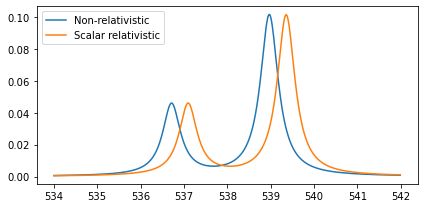

In [13]:
plt.figure(figsize=(6, 3))
# Relativistic and non-relativistc spectra with custom broadening
x, y = au2ev * adc_nr.excitation_energy, adc_nr.oscillator_strength
xi, yi = lorentzian(x, y, 534, 542, 0.01, 0.5)
plt.plot(xi, yi)
x, y = au2ev * adc_rel.excitation_energy, adc_rel.oscillator_strength
xi, yi = lorentzian(x, y, 534, 542, 0.01, 0.5)
plt.plot(xi, yi)
plt.legend(("Non-relativistic", "Scalar relativistic"))
plt.tight_layout()
plt.show()

We see that the spectrum is shifted upwards by $\sim$0.38 eV, due to the increase in core-electron binding energy. The same approach can be used for including these effects also for X-ray emission spectrum  calculations.


### Spin-orbit coupling

Including the spin-orbit effects is more complicated, and can either be

- Included by using 4-component relativistic theory, where they do not need to explicitly addressed

- Included in a non-relativistic approach through a perturbative scheme, or through some *ad hoc* correction 

At the present stage, including spin-orbit effects is beyond the scope of this tutorial.


(sec:xray_topics_basis)=
## Basis set considerations

The basis set requirements of X-ray spectrum calculations depend on which spectroscopy is considered

- XPS and XES probe occupied states, and thus need a good description of those

- XAS and RIXS probe excited states, and thus need an improved description of this region

In all cases the relaxation due to the creation of a core-hole needs to be accommodated, which yields requirements of reasonable flexibility of the core and inner valence region. This is not usually the case for standard basis sets, as they are typically constructed with valence properties in mind and thus have a minimal or close to minimal description of the core region. A number of approaches for improving such valence-focused basis sets have been developed by:

1. Augmenting the Dunning basis sets with core-polarizing functions, *e.g.* cc-pV*n*Z $\rightarrow$ cc-pCV*n*Z

2. Adding extra flexibility by performing full or partial decontraction, such as
    1. Decontracting 1s of the probed element (*e.g.* u6-311++G\*\*, which is based on 6-311++G\*\*)
    2. Fully decontracting the basis set (*e.g.* un6-311++G\*\*, which is based on 6-311++G\*\*)

3. Using basis functions from the next element, as inspired by the $Z+1$ approximation

As an illustration, we consider the IE of water with different basis sets and levels of theory

*Toggle for u6-311G\*\*, un6-311G\*\*, and 6-311G\*\* (Z+1) basis sets.*

```{toggle}
```python
from pyscf import gto

u6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
un6311gss = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                1.000000               1.000000
O    SP
      9.628370               1.000000               1.000000
O    SP
      2.853320               1.000000               1.000000
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
z6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  0.00189515
   1297.230                  0.0143859
    299.2960                 0.0707320
     87.37710                0.2400010
     25.67890                0.5947970
      3.740040               0.2808020
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
O    S
  11427.10                   0.00180093
   1722.350                  0.0137419
    395.7460                 0.0681334
    115.1390                 0.2333250
     33.60260                0.5890860
      4.919010               0.2995050
O    SP
     55.44410                0.114536               0.0354609
     12.63230                0.920512               0.237451
      3.717560              -0.00337804             0.820458
O    SP
      1.165450               1.000000               1.000000
O    SP
      0.321892               1.000000               1.000000
O    D
      1.750                  1.000000
'''), 'H': '6-311G**'}

```python
# Investigated basis sets
basis_sets = [
    "6-311G**",
    u6311gss,
    un6311gss,
    z6311gss,
    "cc-pVDZ",
    "cc-pCVDZ",
    "cc-pVTZ",
    "cc-pCVTZ",
    "cc-pVQZ",
    "cc-pCVQZ",
]

# Containers for IE calculated with four different delta calculations: HF, MP2, CCSD, and B3LYP
ip_hf, ip_mp2, ip_ccsd, ip_b3lyp, n_bas = [], [], [], [], []

for basis in basis_sets:
    # Create pyscf mol object
    mol = gto.Mole()
    mol.atom = water_xyz
    mol.basis = basis
    mol.build()
    # Unrestricted SCF calculation of neutral
    scfres = scf.UHF(mol)
    scfres.kernel()
    # Copy molecular orbitals and change population of 1s
    mo0 = copy.deepcopy(scfres.mo_coeff)
    occ0 = copy.deepcopy(scfres.mo_occ)
    occ0[0][0] = 0.0
    # Unrestricted HF calculation of core-hole and appending delta_HF IP
    scfion = scf.UHF(mol)
    scf.addons.mom_occ(scfion, mo0, occ0)
    scfion.kernel()
    ip_hf.append(au2ev * (scfion.energy_tot() - scfres.energy_tot()))
    # CCSD calculations of neutral and core-hole and appending delta_CCSD IP
    ccsd_res = cc.UCCSD(scfres).run()
    ccsd_ion = cc.UCCSD(scfion).run(max_cycle=500)
    ip_ccsd.append(au2ev * (ccsd_ion.e_tot - ccsd_res.e_tot))
    # Appending delta_MP2 IP
    ip_mp2.append(
        au2ev * (ccsd_ion.e_hf + ccsd_ion.emp2 - (ccsd_res.e_hf + ccsd_res.emp2))
    )
    # Unrestricted KS-DFT calculation of neutral
    scfres = scf.UKS(mol)
    scfres.xc = "b3lyp"
    scfres.kernel()
    # Copy molecular orbitals and change population of 1s
    mo0 = copy.deepcopy(scfres.mo_coeff)
    occ0 = copy.deepcopy(scfres.mo_occ)
    occ0[0][0] = 0.0
    # Unrestricted KS-DFT calculation of core-hole and appending delta_DFT IP
    scfion = scf.UKS(mol)
    scf.addons.mom_occ(scfion, mo0, occ0)
    scfion.xc = "b3lyp"
    scfion.kernel()
    ip_b3lyp.append(au2ev * (scfion.energy_tot() - scfres.energy_tot()))
    # Append basis set size
    n_bas.append(len(scfres.mo_occ[0]))

plt.figure(figsize=(10, 5))
# Plot IEs, with error as a function of basis set size
plt.plot(n_bas, ip_hf, "r*")
plt.plot(n_bas, ip_mp2, "bv")
plt.plot(n_bas, ip_ccsd, "d", color="orange")
plt.plot(n_bas, ip_b3lyp, "go")
plt.legend(("HF", "MP2", "CCSD", "B3LYP", "Expt", "Expt - 0.37 eV"))

# Experimental value as a dotted line, minus relativistic effect as dashed line
plt.plot([min(n_bas) - 5, max(n_bas) + 5], [539.9, 539.9], "k:")
plt.plot([min(n_bas) - 5, max(n_bas) + 5], [539.9 - 0.37, 539.9 - 0.37], "k--")

# Basis set label as x-ticks
basis_set_labels = [
    "6-311G**",
    "u6-311G**",
    "un6-311G**",
    "6-311G** (Z+1)",
    "cc-pVDZ",
    "cc-pCVDZ",
    "cc-pVTZ",
    "cc-pCVTZ",
    "cc-pVQZ",
    "cc-pCVQZ",
]
plt.xticks(n_bas, basis_set_labels, rotation=70, fontsize=10)

# Labels and setting x-interval
plt.ylabel("Ionization energy [eV]")
plt.xlim((min(n_bas) - 5, max(n_bas) + 5))
plt.tight_layout()
plt.show()
```



```{figure} ../../img/xray/basis_xps.svg
---
name: basis_xps
---
```

At the HF and KS-DFT levels of theory we see that some of the smaller basis sets have fortuitous error cancellations, such that both 6-311G\*\* and cc-pVTZ yield results close to experimental values. However, augmenting these basis sets with more functions in the core region brings us away from experimental measurements (note that the calculations do not include relativistic effects, so the comparison would be toward experiment minus relativistic shift, *i.e.* the dashed line).

With MP2 and CCSD we note very similar results for the smaller basis sets, which then deviate significantly for cc-pVTZ and above. $\Delta$CCSD estimates using core-polarized cc-pVTZ and cc-pVQZ are well in line with experimental measurements. Augmenting the 6-311G\*\* basis sets with a decontracted core region (u6-311G\*\*) yields some improvement at a relatively low increase in computational cost, and further decontracting the full set (un6-311G\*\*) or adding basis functions from $Z+1$ (6-311G\*\* (Z+1)) provides some additional improvement.


(sec:xray_topics_sie)=
## Self-interaction error in DFT

For a single-electron systems the following equality should hold for the two-electron terms:

$$
J[\rho] + E_{xc} [\rho] = 0
$$

This cancellation is preserved within HF theory, but for any approximate functionals in KS-DFT the equality will no longer hold, resulting in the potentially significant errors due to spurious self-interactions. Reformulated, the Coulomb self-repulsion of each electron included in the Coulomb operator is exactly canceled by the nonlocal exchange self-attraction in Hartree-Fock, but this is no longer the case when the exchange operator is replaced by an approximate exchange functional.

As such, KS-DFT possess a self-interaction error (SIE), which shows a strong dependence on how compact the respective MOs are. This means that the self-interaction error is significantly more influential for core properties than for valence properties, and the tendency to decontract core orbitals due to the SIE has an opposite effect on transition energies as compared to relaxation effects.

Let us consider the ionization energy of water, as calculated with MO energies and $\Delta\textrm{SCF}$ using two different exchange-correlation functionals with variable HF exchange: 

```{note}
Using MO energies for TDHF and TDDFT yields the same IE as when addressing core-transitions to extremely diffuse basis functions (due to the lack of relaxation), and is thus representative of the error for such XAS calculations.
```

```python
# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = "6-31G"
mol.build()

# Investigated HF exchange and result containers
hf_exc = [0.0, 0.25, 0.50, 0.75, 1.0]
hf_blyp, hf_pbe = [[], []], [[], []]


def dft_delta(mol, xc):
    # Neutral calculation
    dft_res = scf.UKS(mol)
    dft_res.xc = xc
    dft_res.kernel()
    # Core-hole calculation
    mo0 = copy.deepcopy(dft_res.mo_coeff)
    occ0 = copy.deepcopy(dft_res.mo_occ)
    occ0[0][0] = 0.0
    dft_ion = scf.UKS(mol)
    dft_ion.xc = xc
    scf.addons.mom_occ(dft_ion, mo0, occ0)
    dft_ion.kernel()
    return -au2ev * dft_res.mo_energy[0][0], au2ev * (
        dft_ion.energy_tot() - dft_res.energy_tot()
    )


for h_x in hf_exc:
    # BxLYP (Slater exchange 0.08, except when HF i 1.00)
    if h_x == 1.0:
        s_x = 0.00
    else:
        s_x = 0.08
    b_x = 1.00 - h_x - s_x
    v_e, v_l = 0.19, 0.81
    xc = f"{h_x:} * HF + {s_x:} * Slater + {b_x:} * B88, {v_l:} * LYP + {v_e:} * VWN"
    E_mo, E_delta = dft_delta(mol, xc)
    hf_blyp[0].append(E_mo)
    hf_blyp[1].append(E_delta)
    # PBEx
    p_x = 1.0 - h_x
    xc = f"{h_x:} * HF + {p_x:} * PBE, PBE"
    E_mo, E_delta = dft_delta(mol, xc)
    hf_pbe[0].append(E_mo)
    hf_pbe[1].append(E_delta)
```

```python
plt.figure(figsize=(6, 4))
# DFT ionization energies, including scalar relativistic shift
plt.plot(hf_exc, np.array(hf_blyp[0]) + 0.37, "bs--")
plt.plot(hf_exc, np.array(hf_blyp[1]) + 0.37, "ro--")
plt.plot(hf_exc, np.array(hf_pbe[0]) + 0.37, "d--", color="orange")
plt.plot(hf_exc, np.array(hf_pbe[1]) + 0.37, "g^--")

# Experimental value and legend
plt.plot([-0.1, 1.1], [539.9, 539.9], "k-")
plt.legend(
    (r"BxLYP ($\Delta$SCF)", "BxLYP (MO)", r"PBEx ($\Delta$SCF)", "PBEx (MO)", "Expt")
)

plt.xlim((-0.025, 1.025))
plt.ylim((508, 562.0))
plt.xlabel("HF exchange [%]")
plt.ylabel("Ionization energy [eV]")
plt.tight_layout()
plt.show()
```


```{figure} ../../img/xray/sie.svg
---
name: xray_sie
scale: 6%
---
```

We see that the $\Delta$SCF errors are quite constant between the two base functionals and amounts of HF exchange, while the MO energies strongly scale with HF exchange, but not with the base functional. The total MO error is a function of two effects:

1. Lack of relaxation, which generally leads to an overestimation of IEs and core-excitation energies

2. Self-interaction, which by contrast leads to an underestimation of these energies

For a typical exchange-correlation functional ($\sim$20-25% HF exchange) the SIE thus dominates, and by tuning the (global) HF exchange to around 60% we achieve IE estimates in good agreement to experiment. We note that this is only acheieved by cancellation of the above two errors, and does not mean that we have an appropriate description of the core-excitation processes. Furthermore, a good exchange-correlation functional should possess good energies *and* densities, and focusing on only energies can push us away from such a goal. Nevertheless, a number of tailored functionals with good absolute energies have been constructed, tuning the HF exchange either in a global or range-separated manner. Note that the parameterization will have to depend on the spectroscopy, probed edge, and row of the periodic table, as the exact balance in relaxation terms and SIE varies.



(sec:xray_topics_chloc)=
## Core-hole localization

For $\Delta$ SCF calculations (either for estimating IEs or as a initial state for XES), a core-hole is created at some atomic site. For many systems, this is unproblematic, but if chemically equivalent atoms are present, the MOs are delocalized over these sites. Performing a straightforward $\Delta$SCF calculation will then results in a delocalized core-hole, as illustrated below for ethene:


```python
ethene_xyz = """
C0      0.6660048050     0.0000000000    -0.0000000000
C1     -0.6660048050    -0.0000000000     0.0000000000
H       1.2278735620     0.9228358077    -0.0000000000
H       1.2278735620    -0.9228358077    -0.0000000000
H      -1.2278735620     0.9228358077     0.0000000000
H      -1.2278735620    -0.9228358077     0.0000000000
"""


def Koopman_vs_delta(molecule, basis, ecp=None):
    # Create pyscf mol object
    mol = gto.Mole()
    mol.atom = molecule
    mol.basis = basis
    if ecp:
        mol.ecp = ecp
    mol.build()
    # Perform unrestricted SCF calculation
    scf_gs = scf.UHF(mol)
    scf_gs.kernel()
    # Copy molecular orbitals
    mo0 = copy.deepcopy(scf_gs.mo_coeff)
    occ0 = copy.deepcopy(scf_gs.mo_occ)
    # Create 1s core-hole by setting alpha_0 population to zero
    occ0[0][0] = 0.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Return MO energy and deltaSCF
    return -au2ev * scf_gs.mo_energy[0][0], au2ev * (
        scf_ion.energy_tot() - scf_gs.energy_tot()
    )


# All-electron calculation of IP
delta_all = Koopman_vs_delta(ethene_xyz, "unc-6-31G")

# IE calculation with ECP on one carbon
delta_ecp = Koopman_vs_delta(ethene_xyz, "unc-6-31G", {"C0": "stuttgart"})
```

```python
plt.figure(figsize=(5, 3))
# IE estimates with all-electron (delocalized core-hole)
plt.plot([1, 2], [delta_all[0] + 0.11, delta_all[1] + 0.11], "ro")

# IE estimates with ECP (localized core-hole)
plt.plot([1, 2], [delta_ecp[0] + 0.11, delta_ecp[1] + 0.11], "bs")

# Experiment and figure settings
plt.plot([0.5, 2.5], [290.80, 290.80], "k--")
plt.ylabel("Ionization energy [eV]")
plt.xticks([1, 2], ("MO", r"$\Delta$SCF"))
plt.xlim((0.5, 2.5))
plt.tight_layout()
plt.show()
```


```{figure} ../../img/xray/ch_loc.svg
---
name: xray_ch_loc
scale: 6%
---
```

As can be seen, the errors from MO energies are very similar for the all-electron calculation (with a delocalized core-hole) and using ECP (delocalized core-hole). For the $\Delta$SCF calculation, however, only approximately half the relaxation energy is accounted for using a delocalized core-hole. Such a discrepancy for delocalized calculations of IEs has been noted [previously](https://doi.org/10.1063/1.1676850), and it has been [associated](https://doi.org/10.1063/1.433763) with missing correlation effects which are required to properly correct the delocalized calculation. Within a full CI scheme, delocalization will no longer be an issue (and it will capture the small shift in energy between the gerade and ungerade core-hole).

Moving from theory, in experiment the localizatio/delocalization of core-holes is primarily relevant for diatomic systems, as other compounds will possess vibrational effects which break the symmetry. For diatomic systems the localized/delocalized nature of the core-hole has been seen to depend on the details of the measurement, such that both can be probed [ref].

As such, for practical calculation we [recommend](https://doi.org/10.1063/5.0088195) that core-holes are localized for IE and XES calculations. For XAS it does not provide any issues for linear response methods (provided that both gerade and ungerade MOs are kept in the CVS space/equivalent), but for state-specific approaches this will again be an issue (*e.g.* STEX and TP-DFT).



(sec:xray_topics_tailcvs)=
## Tailored CVS


For large systems, it may become relevant to tailor the CVS space such that each chemically unique atom is probed in turn. While this requires explicit consideration of each set of unique MOs separately, it serves dual purposes which can make it worth it:

1. It lowers the dimensionality of the involved matrices, and thus decrease computational costs

2. The density-of-states decrease, which means that the same energy region can be resolved with a few states per unique MO, rather than having to converge a large number of eigenstates simultaneously


While this technically does not fulfill one of foundations on which the CVS approximation is built (the MOs are not energetically well-separated), the spatial separation means that it will typically work. As an example, we consider ethene (which has delocalized MOs) and vinylfluoride (which does not):


```python
vinyl_xyz = """
 C     0.000000    -0.246412    -1.271068
 C     0.000000     0.457081    -0.154735
 F     0.000000    -0.119195     1.052878
 H     0.000000     0.272328    -2.210194
 H     0.000000    -1.319906    -1.249847
 H     0.000000     1.530323    -0.095954
"""

print("Ethene")
# Create pyscf mol object
mol = gto.Mole()
mol.atom = ethene_xyz
mol.basis = "6-31G"
mol.build()
# Perform restricted SCF calculation
scf_gs = scf.RHF(mol)
scf_gs.kernel()
# Perform CVS-ADC calculations
ethene_adc1_0 = adcc.cvs_adc1(scf_gs, n_singlets=4, core_orbitals=[0])
ethene_adc1_1 = adcc.cvs_adc1(scf_gs, n_singlets=4, core_orbitals=[1])
ethene_adc1_01 = adcc.cvs_adc1(scf_gs, n_singlets=4, core_orbitals=[0, 1])
ethene_adc2_0 = adcc.cvs_adc2(scf_gs, n_singlets=4, core_orbitals=[0])
ethene_adc2_1 = adcc.cvs_adc2(scf_gs, n_singlets=4, core_orbitals=[1])
ethene_adc2_01 = adcc.cvs_adc2(scf_gs, n_singlets=4, core_orbitals=[0, 1])

print("Vinylfluoride")
# Create pyscf mol object
mol = gto.Mole()
mol.atom = vinyl_xyz
mol.basis = "6-31G"
mol.build()
# Perform restricted SCF calculation
scf_gs = scf.RHF(mol)
scf_gs.kernel()
# Perform CVS-ADC calculations
vinyl_adc1_1 = adcc.cvs_adc1(scf_gs, n_singlets=4, core_orbitals=[1])
vinyl_adc1_2 = adcc.cvs_adc1(scf_gs, n_singlets=4, core_orbitals=[2])
vinyl_adc1_12 = adcc.cvs_adc1(scf_gs, n_singlets=4, core_orbitals=[0, 1, 2])
vinyl_adc2_1 = adcc.cvs_adc2(scf_gs, n_singlets=4, core_orbitals=[1])
vinyl_adc2_2 = adcc.cvs_adc2(scf_gs, n_singlets=4, core_orbitals=[2])
vinyl_adc2_12 = adcc.cvs_adc2(scf_gs, n_singlets=4, core_orbitals=[0, 1, 2])
```


```python
plt.figure(figsize=(10, 6))
# Ethene with CVS-ADC(1)
plt.subplot(221)
plt.title("Ethene")
ethene_adc1_0.plot_spectrum(label="MO #0")
ethene_adc1_1.plot_spectrum(label="MO #1")
ethene_adc1_01.plot_spectrum(label="MOs #0-1")
plt.legend()
plt.ylabel("CVS-ADC(1)")

# Vinylfluoride with CVS-ADC(1)
plt.subplot(222)
plt.title("Vinylfluoride")
vinyl_adc1_1.plot_spectrum(label="MO #1")
vinyl_adc1_2.plot_spectrum(label="MO #2")
vinyl_adc1_12.plot_spectrum(label="MO #1-2")
plt.legend()

# Ethene with CVS-ADC(2)
plt.subplot(223)
ethene_adc2_0.plot_spectrum()
ethene_adc2_1.plot_spectrum()
ethene_adc2_01.plot_spectrum()
plt.ylabel("CVS-ADC(2)")

# Vinylfluoride with CVS-ADC(2)
plt.subplot(224)
vinyl_adc2_1.plot_spectrum()
vinyl_adc2_2.plot_spectrum()
vinyl_adc2_12.plot_spectrum()

plt.tight_layout()
plt.show()
```



```{figure} ../../img/xray/adc_cvs.svg
---
name: xray_adc_cvs
scale: 6%
---
```

We see that considering each MO in turn works well for vinylfluoride, where the two carbon 1s are localized, but not for ethene, where they are delocalized. Including or not including fluorine here makes little difference, as that MO is both energetically and spatially well separated from the carbon 1s.

Note that the delocalization [might](https://doi.org/10.1063/5.0088195) not be immediatelly apparent, as just visually looking at the molecule and concluding which atoms are unique might not be sufficient. Care should be taken for larger systems, and explicitly looking at the MOs is advised. Alternatively, using ECPs to localize the core-hole and then restricting the CVS space accordingly will avoid this issue.
    

(sec:xray_topics_nonaufbau)=
## Post-HF on a non-Aufbau reference


```{note}
- Include a discussion on the potential issues in using post-HF methods for a non-*Aufbau* reference state, as can be seen by noting the MP2 energy denominator (and potential singularities, and discusses [here](https://doi.org/10.1039/D2CP00584K))
- Include explicit example:
    1. Go over all permutations (aa, ab, bb), saving the highest MO index which yields denominators below 0.1 au. Just have a list of virtual indices, adding when an index is not already found there. Do this in one shot, instead of saving one virtual at a time.
    2. Compare this to the scheme in adcc, noting that the present (simpler) scheme is likely just as useful - despite not ordering indices by how problematic they are.
    3. Use this to calculate the ADC(2)/cc-pCVQZ spectra of ammonia, with and without frozen virtuals.
```



(sec:xray_cons_spur_val)=
## Spurious valence mixing in XAS

Within a damped response theory framework or when performing explicit real-time propagation, a CVS-like scheme which separates core-transitions from the valence-continuum is usually not performed. If such calculations are run with an atom-centered basis set (as most are), this can then lead to spurious mixing with valence-excited states. What happens is that resonances in the valence-continuum occur close to core-excitations, leading to unphysical mixing which affects excitation energies and (more significantly) intensities. These issues occur both for methods featuring only single-excited configurations (*e.g.* TDDFT) and higher-excited configurations (*e.g.* ADC) and need to be avoided.

These issues have been observed for, *e.g.*, $L_{2,3}$-edge of silicon {cite}`xas4crttddft, ledge2016`, and are usually more common at lower energies. They can be identified by studying the amplitudes and the $t^2$ values for post-HF methods, and can be avoided by chosing appropriate basis sets, freezing certain virtual orbitals, or by re-introducing the CVS approximation (or some other flavour) within the CPP/RT framework. The latter approach is recommended at least for CPP-ADC, as converging the response vectors has otherwise been seen to be difficult {cite}`gator`.